## 1. Importing the Tools

----------------------

We import standard processing tools like numpy and pandas as well as Natural Language Toolkit (NLTK) and Sklearn for language-focused support and machine learning, respectively. 

In [242]:
import string
import pandas as pd
import numpy as np
import requests
import re

from bs4 import BeautifulSoup

from nltk.tokenize import StanfordTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

from scipy.cluster.hierarchy import ward, dendrogram

from pyquery import PyQuery as pq
import sqlite3

import matplotlib.pyplot as plt
%matplotlib inline

## 2. Reading in the Labeled Data

----------------------------------------------------------------------

A list of characters and other data was provided and wsa read in using Pandas. The data is tab-separated and contains the gender, number of lines, the play, and whether the character is a villan or a fool. 

In [2]:
## read in the character list
given = pd.read_csv('Shakespeare_characters.txt', delimiter='\t', encoding='ISO-8859-1')
given = given.drop('Unnamed: 1', axis=1)
given.head()

,Speaker,Gender,#Lines,Play,TopVillain,Fools
0,Hamlet,Male,1506,Hamlet,NaN,NaN
1,Iago,Male,1088,Othello,yes,NaN
2,King Henry,Male,1031,Henry V,NaN,NaN
3,Othello,Male,880,Othello,NaN,NaN
4,Timon,Male,850,Timon of Athens,NaN,NaN


In [3]:
given.tail()

,Speaker,Gender,#Lines,Play,TopVillain,Fools
1528,First And Second Murderer,Male,1,Richard III,NaN,NaN
1529,All,Male,1,Richard III,NaN,NaN
1530,Ghost Of Grey,Male,1,Richard III,NaN,NaN
1531,Herbert,Male,1,Richard III,NaN,NaN
1532,Queen Elizabeth And Duchess Of York,Female,1,Richard III,NaN,NaN


In [4]:
print(given['#Lines'].describe())

count    1533.000000
mean       74.281800
std       136.406005
min         1.000000
25%         4.000000
50%        18.000000
75%        73.000000
max      1506.000000
Name: #Lines, dtype: float64


According to the data provided, there's a total of 1531 characters. The characters have a mean of approximately 74 lines, but have a median of 18 lines. 

## 3. Scraping Shakespeare 

----------------------------------

To obtain all of the Shakespeare text, we scrape the MIT Shakespeare page and commit all of the scraped data to a SQLite database.

In [5]:
from pyquery import PyQuery as pq
import sqlite3

conn = sqlite3.connect("shakespeare.db")
cursor = conn.cursor()
print("opened conn to db")

cursor.execute('''
    CREATE TABLE IF NOT EXISTS corpus(
        CHARACTER  TEXT             NOT NULL,
        PLAY       TEXT             NOT NULL,
        ACT        INT              NOT NULL,
        SCENE      INT              NOT NULL,
        UTTERANCE  TEXT             NOT NULL );
        
        ''')
conn.commit()

cursor.execute("DELETE FROM corpus")
conn.commit()

conn.close()
print("db is closed")

opened conn to db
db is closed


In [6]:
conn = sqlite3.connect("shakespeare.db")
print("conn is open")

baseurl = "http://shakespeare.mit.edu/"
d = pq(baseurl)
links = d("td a")
plays = [baseurl + pq(a_tag).attr.href for a_tag in links[:-7]]

def get_lines_for_play(url, act, scene, play_name):
    page = pq(url)
    characters = page("a[name*=speech]")
    char_lines = page("blockquote").filter(lambda: not pq(this).children("i"))
    data = []
    for char, lines in zip(characters, char_lines):
        char_name = pq(char).text()
        char_speech = pq(lines)("a").text()
        data.append({
            "play": play_name,
            "act": act,
            "scene": scene,
            "character": char_name,
            "utterance": char_speech
        })
    return data

def insert_into_db(conn, scene_data):
    cursor = conn.cursor()
    for row in scene_data:
        cursor.execute("""
            INSERT INTO corpus (play, act, scene, character, utterance)
            VALUES (:play, :act, :scene, :character, :utterance);
            """, row)
        conn.commit()
    
for play in plays:
    print("scraping: ", play)
    play_page = pq(play)
    for tag in play_page("p a"):
        link = pq(tag).attr.href
        try:
            act_page = play_page.base_url.replace("index.html", link)
            play_name, act, scene, _fileext = link.split(".")
            scene_data = get_lines_for_play(act_page, int(act), int(scene), play_name)
            insert_into_db(conn, scene_data)
        except Exception as e:
             print(e)

conn.close()
print("db is closed")

conn is open
scrapping:  http://shakespeare.mit.edu/allswell/index.html
not enough values to unpack (expected 4, got 3)
not enough values to unpack (expected 4, got 2)
scrapping:  http://shakespeare.mit.edu/asyoulikeit/index.html
not enough values to unpack (expected 4, got 3)
not enough values to unpack (expected 4, got 2)
HTTPConnectionPool(host='shakespeare.mit.edu', port=80): Max retries exceeded with url: /asyoulikeit/asyoulikeit.3.5.html (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x11b2ce470>: Failed to establish a new connection: [Errno 60] Operation timed out',))
scrapping:  http://shakespeare.mit.edu/comedy_errors/index.html
not enough values to unpack (expected 4, got 3)
not enough values to unpack (expected 4, got 2)
scrapping:  http://shakespeare.mit.edu/cymbeline/index.html
not enough values to unpack (expected 4, got 3)
not enough values to unpack (expected 4, got 2)
scrapping:  http://shakespeare.mit.edu/lll/index.html
n

After we've stored all of the pertinent data, we can then access it via Pandas SQL to create dataframes.

## 4. Text Data Preparation

Now that we've collected all the data we need and can access it, we can then move forward with preparing the data for clustering analysis. We need to remove the punctuation and make the words lower case to start.

Note, some of these data preparation techniques are available in the vectorizer in the next sections but it's useful to do it explicitly to understand the data.

In [103]:
conn = sqlite3.connect("shakespeare.db")
print("conn is open")
text_df = pd.read_sql_query('select * from corpus', con=conn)
conn.close()
print('conn is closed')

conn is open
conn is closed


In [104]:
text_df.columns = [['character', 'play', 'act', 'scene', 'utterance']]
text_df.head()

,character,play,act,scene,utterance
0,COUNTESS,allswell,1,1,"In delivering my son from me, I bury a second ..."
1,BERTRAM,allswell,1,1,"And I in going, madam, weep o'er my father's d..."
2,LAFEU,allswell,1,1,"You shall find of the king a husband, madam; y..."
3,COUNTESS,allswell,1,1,What hope is there of his majesty's amendment?
4,LAFEU,allswell,1,1,"He hath abandoned his physicians, madam; under..."


In [105]:
text_df['character'] = text_df.character.apply(lambda x: str.lower(x))
text_df['utterance'] = text_df.utterance.apply(lambda x: str.lower(x))

In [106]:
text_df.head()

,character,play,act,scene,utterance
0,countess,allswell,1,1,"in delivering my son from me, i bury a second ..."
1,bertram,allswell,1,1,"and i in going, madam, weep o'er my father's d..."
2,lafeu,allswell,1,1,"you shall find of the king a husband, madam; y..."
3,countess,allswell,1,1,what hope is there of his majesty's amendment?
4,lafeu,allswell,1,1,"he hath abandoned his physicians, madam; under..."


In [108]:
text_df.tail()

,character,play,act,scene,utterance
30750,young lucius,titus,5,3,"o grandsire, grandsire! even with all my heart..."
30751,aemilius,titus,5,3,"you sad andronici, have done with woes: give s..."
30752,lucius,titus,5,3,"set him breast-deep in earth, and famish him; ..."
30753,aaron,titus,5,3,"o, why should wrath be mute, and fury dumb? i ..."
30754,lucius,titus,5,3,"some loving friends convey the emperor hence, ..."


Next we remove punctuation. We also remove common words like "thou", "thy", and "shall".

In [109]:
text_df['utterance'] = text_df.utterance.apply(lambda x: "".join(i for i in x if i not in string.punctuation))
exclude_list = ['thee', 'thy', 'thou', 'shall', 'come', 'lord', 'king', 'grace']
text_df['utterance'] = text_df.utterance.apply(lambda x: " ".join(i for i in x.split() if i not in exclude_list))

In [110]:
text_df.head()

,character,play,act,scene,utterance
0,countess,allswell,1,1,in delivering my son from me i bury a second h...
1,bertram,allswell,1,1,and i in going madam weep oer my fathers death...
2,lafeu,allswell,1,1,you find of the a husband madam you sir a fath...
3,countess,allswell,1,1,what hope is there of his majestys amendment
4,lafeu,allswell,1,1,he hath abandoned his physicians madam under w...


In [111]:
text_df.tail()

,character,play,act,scene,utterance
30750,young lucius,titus,5,3,o grandsire grandsire even with all my heart w...
30751,aemilius,titus,5,3,you sad andronici have done with woes give sen...
30752,lucius,titus,5,3,set him breastdeep in earth and famish him the...
30753,aaron,titus,5,3,o why should wrath be mute and fury dumb i am ...
30754,lucius,titus,5,3,some loving friends convey the emperor hence a...


After removing punctuation, we then move on to remove stop words and lemmatize the utternaces. 

In [113]:
text_df['utterance'] = text_df.utterance.apply(lambda x: " ".join(i for i in x.split() if i not in stopwords.words('english')))
wnl = WordNetLemmatizer()
text_df['utterance'] = text_df.utterance.apply(lambda x: " ".join(wnl.lemmatize(i) for i in x.split()))

In [114]:
text_df.head()

,character,play,act,scene,utterance
0,countess,allswell,1,1,delivering son bury second husband
1,bertram,allswell,1,1,going madam weep oer father death anew must at...
2,lafeu,allswell,1,1,find husband madam sir father generally time g...
3,countess,allswell,1,1,hope majesty amendment
4,lafeu,allswell,1,1,hath abandoned physician madam whose practises...


In [115]:
text_df.tail()

,character,play,act,scene,utterance
30750,young lucius,titus,5,3,grandsire grandsire even heart would dead live...
30751,aemilius,titus,5,3,sad andronici done woe give sentence execrable...
30752,lucius,titus,5,3,set breastdeep earth famish let stand rave cry...
30753,aaron,titus,5,3,wrath mute fury dumb baby base prayer repent e...
30754,lucius,titus,5,3,loving friend convey emperor hence give burial...


We then create a dictionary of plays, with list of characters as their value.

In [162]:
all_plays = list(set(text_df.play.values))
play_character_dict = {}
for play in all_plays:
    play_character_dict[play] = list(set(text_df.character[text_df.play==play]))

Finally, we obtain all of the words a characters has said. 

In [118]:
def get_all_text(character, scraped_df):
    character = scraped_df[scraped_df.character == character]
    character_text = character.utterance.values
    character_text = " ".join( character_text )
    return(character_text)

In [120]:
## an example
get_all_text('romeo', text_df)

'day young ay sad hour seem long father went hence fast make short  favour love ala love whose view muffled still without eye see pathway dine fray yet tell heard here much hate love brawling love loving hate thing nothing first create heavy lightness serious vanity misshapen chaos wellseeming form feather lead bright smoke cold fire sick health stillwaking sleep love feel feel love dost laugh good heart love transgression grief mine lie heavy breast wilt propagate prest thine love hast shown doth add grief much mine love smoke raised fume sigh purged fire sparkling lover eye vexd sea nourishd lover tear else madness discreet choking gall preserving sweet farewell coz tut lost romeo he groan tell bid sick man sadness make ah word ill urged one ill sadness cousin love woman right good markman shes fair love well hit miss shell hit cupid arrow hath dians wit strong proof chastity well armd love weak childish bow life unharmd stay siege loving term bide encounter assailing eye ope lap sai

Then we can create a dictionary where the character is the key and their utterances are the value. 

In [146]:
def prep_dict(characters, text_df):
    prepped_dict = {}
    for character in characters:
        prepped_dict[character] = get_all_text(character, text_df)
    return(prepped_dict)

The text below represents all of Romeo's (Romeo and Juliet) utterances, for example. Of course, this would be done for all of the characters in a play for convenience in the operations that follow. 

In [148]:
prep_dict(['romeo'], text_df)

{'romeo': 'day young ay sad hour seem long father went hence fast make short  favour love ala love whose view muffled still without eye see pathway dine fray yet tell heard here much hate love brawling love loving hate thing nothing first create heavy lightness serious vanity misshapen chaos wellseeming form feather lead bright smoke cold fire sick health stillwaking sleep love feel feel love dost laugh good heart love transgression grief mine lie heavy breast wilt propagate prest thine love hast shown doth add grief much mine love smoke raised fume sigh purged fire sparkling lover eye vexd sea nourishd lover tear else madness discreet choking gall preserving sweet farewell coz tut lost romeo he groan tell bid sick man sadness make ah word ill urged one ill sadness cousin love woman right good markman shes fair love well hit miss shell hit cupid arrow hath dians wit strong proof chastity well armd love weak childish bow life unharmd stay siege loving term bide encounter assailing eye o

## 5. Vectorization 

After we've created our character dictionary, we can create a term frequency inverse document frequency (tf-idf) matrix. This is an example of vectorization across the whole scraped corpus.

In [149]:
all_characters = list(set(text_df.character.values))
tfidf_vectorizer = TfidfVectorizer() ## will play with parameters in next sections
%time tfidf_matrix = tfidf_vectorizer.fit_transform(prep_dict(all_characters, text_df).values()) 

CPU times: user 3.33 s, sys: 20.3 ms, total: 3.35 s
Wall time: 3.35 s


In [150]:
tfidf_matrix.shape

(951, 23958)

A list of all of the terms in the matrix can be seen here:

In [151]:
terms = tfidf_vectorizer.get_feature_names()
terms

['10',
 '2d',
 '4d',
 '6d',
 '8d',
 'aaron',
 'abaissiez',
 'abandon',
 'abandond',
 'abandoned',
 'abandonwhich',
 'abase',
 'abashd',
 'abate',
 'abated',
 'abatement',
 'abates',
 'abbess',
 'abbey',
 'abbeygate',
 'abbeywall',
 'abbeywalls',
 'abbominable',
 'abbot',
 'abbreviated',
 'abed',
 'abel',
 'abergavenny',
 'abet',
 'abetting',
 'abhominablewhich',
 'abhor',
 'abhorrd',
 'abhorrdst',
 'abhorred',
 'abhorring',
 'abhors',
 'abhorson',
 'abide',
 'abides',
 'ability',
 'abirding',
 'abject',
 'abjectly',
 'abjects',
 'abjure',
 'abjured',
 'able',
 'ableeding',
 'abler',
 'aboard',
 'abode',
 'aboded',
 'abodements',
 'abominable',
 'abominably',
 'abomination',
 'abortive',
 'abortives',
 'abound',
 'abounding',
 'aboundst',
 'abraham',
 'abram',
 'abrawl',
 'abreast',
 'abreeding',
 'abrewing',
 'abridge',
 'abridged',
 'abridgement',
 'abridgment',
 'abroach',
 'abroad',
 'abrogate',
 'abrooch',
 'abrook',
 'abrupt',
 'abruption',
 'abruptly',
 'absence',
 'absent',
 'ab

## 6. K-Means Clustering and Visualization

In order to carry out the K-Means clustering in a meaningful way, we must create a function in order to build the visualizations that will help us discover groups of similar characters. Some of the operations from above are integrated in the function below. There is a feature reduction parameter which implements Truncated Single Value Decomposition (a form of PCA feature reduction for sparse matrices). 

In [223]:
## this is the k-means clustering function
def clustering(play, character_list, text_df, vectorizer, feat_reduct=False, n_components=100, num_clusters=3):
    tfidf_vectorizer = vectorizer ## see documentation for all available params
    tfidf_matrix = tfidf_vectorizer.fit_transform(prep_dict(character_list, text_df).values()) 
    
    if feat_reduct == False:
        km = KMeans(n_clusters=num_clusters)
        km.fit(tfidf_matrix)
        clusters = km.labels_.tolist()
        cluster_dict = dict(zip(character_list, clusters))
        
    else:
        rpca= TruncatedSVD(n_components=n_components, algorithm='randomized')
        rpca = rpca.fit_transform(tfidf_matrix)
        km = KMeans(n_clusters=num_clusters)
        km.fit(rpca)
        clusters = km.labels_.tolist()
        cluster_dict = dict(zip(character_list, clusters))
    
    #set up colors per clusters using a dict
    # this is always k=3
    cluster_colors = {0: 'red', 1: 'blue', 2: 'green'}
    #cluster_colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow', 4: 'orange'}

    cluster_names = {}
    
    # get the most common words in the cluster
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(num_clusters):
        cluster_names[i] = [terms[ind] for ind in order_centroids[i, :5]]
    
    # distance metric
    dist = 1 - cosine_similarity(tfidf_matrix)
    
    MDS()
    
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]
    
    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, character=character_list)) 

    #group by cluster
    groups = df.groupby('label')


    # set up plot
    fig, ax = plt.subplots(figsize=(17, 9)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    # iterate through groups to layer the plot
    # note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_names[name], color=cluster_colors[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='off')
    
    ax.legend(numpoints=1)  # show legend with only 1 point

    # add label in x,y position with the label as the film title
    for i in range(len(df)):
        ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['character'], size=8)
    plt.title('Play: {0}'.format(play))
    plt.show() #show the plot
    #uncomment the below to save the plot if need be
    #plt.savefig('clusters_small_noaxes.png', dpi=200)

## 8. Comparison of Similarities

We use k=3 clusters to represent the groups of characters with the idea that there are groups of protaganosists, antagonists, and support or "others" types of characters. We also use a max_df and min_df of 95% and 5% respectively, to capture the words that represent the words that are in at least 5% of the utterances, and in less than 95% of the utterances. 

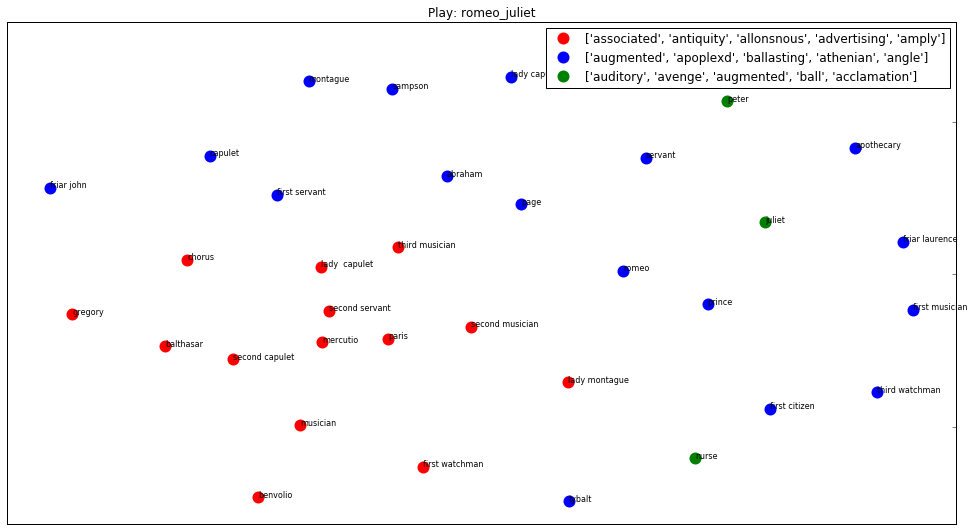

In [226]:
## without feature reduction
vectorizer = TfidfVectorizer(max_df=.95, min_df=.05)
clustering('romeo_juliet', play_character_dict['romeo_juliet'], text_df, vectorizer)

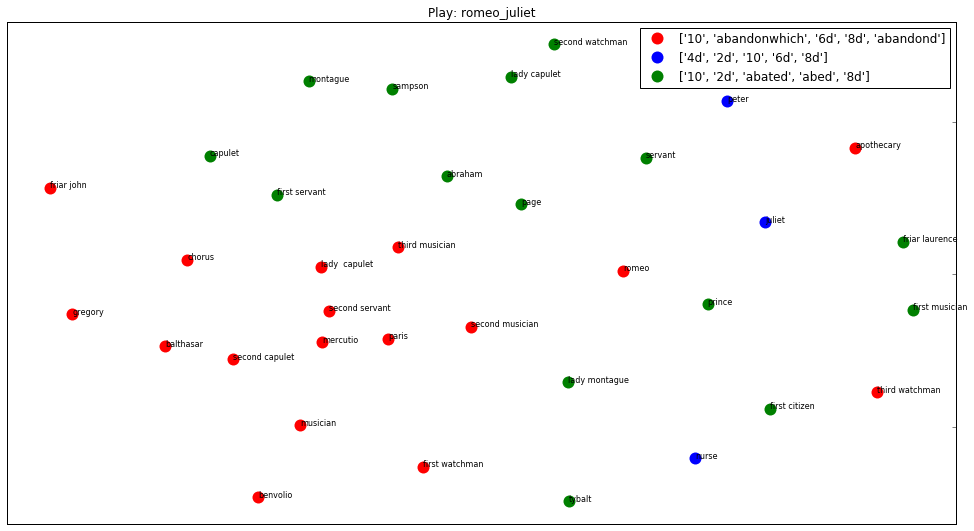

In [227]:
## with feature reduction
vectorizer = TfidfVectorizer(max_df=.95, min_df=.05)
clustering('romeo_juliet', play_character_dict['romeo_juliet'], text_df, vectorizer, feat_reduct=True)

In the first clusters, the membership stays fairly consistent and the distances between the characters are the same, but there are some characters who move from one cluster to another. For example, the the Third Watchman was previously in the blue cluster and moved to the red cluster in the feature reduction version of the clustering.

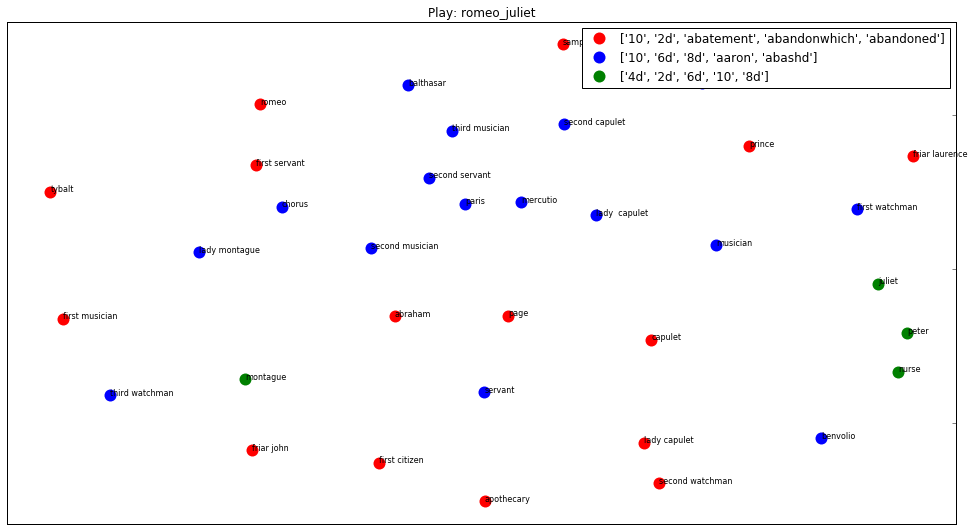

In [228]:
## with feature reduction and n-grams
vectorizer = TfidfVectorizer(max_df=.95, min_df=.05, ngram_range=(1,4))
clustering('romeo_juliet', play_character_dict['romeo_juliet'], text_df, vectorizer, feat_reduct=True)

In the n-gram version of the clustering, the distances between the characters change, as well as the cluster memberships. 

## 9. Hierarchical Clustering 

Attempting a different approach to clustering Romeo and Juliet, we applied Hierarchical (Ward) Clustering to the play. We reuse the vetctoriation methods and distance metric from above and simply feed the data to the Ward clustering API.

In [256]:
## functionize this

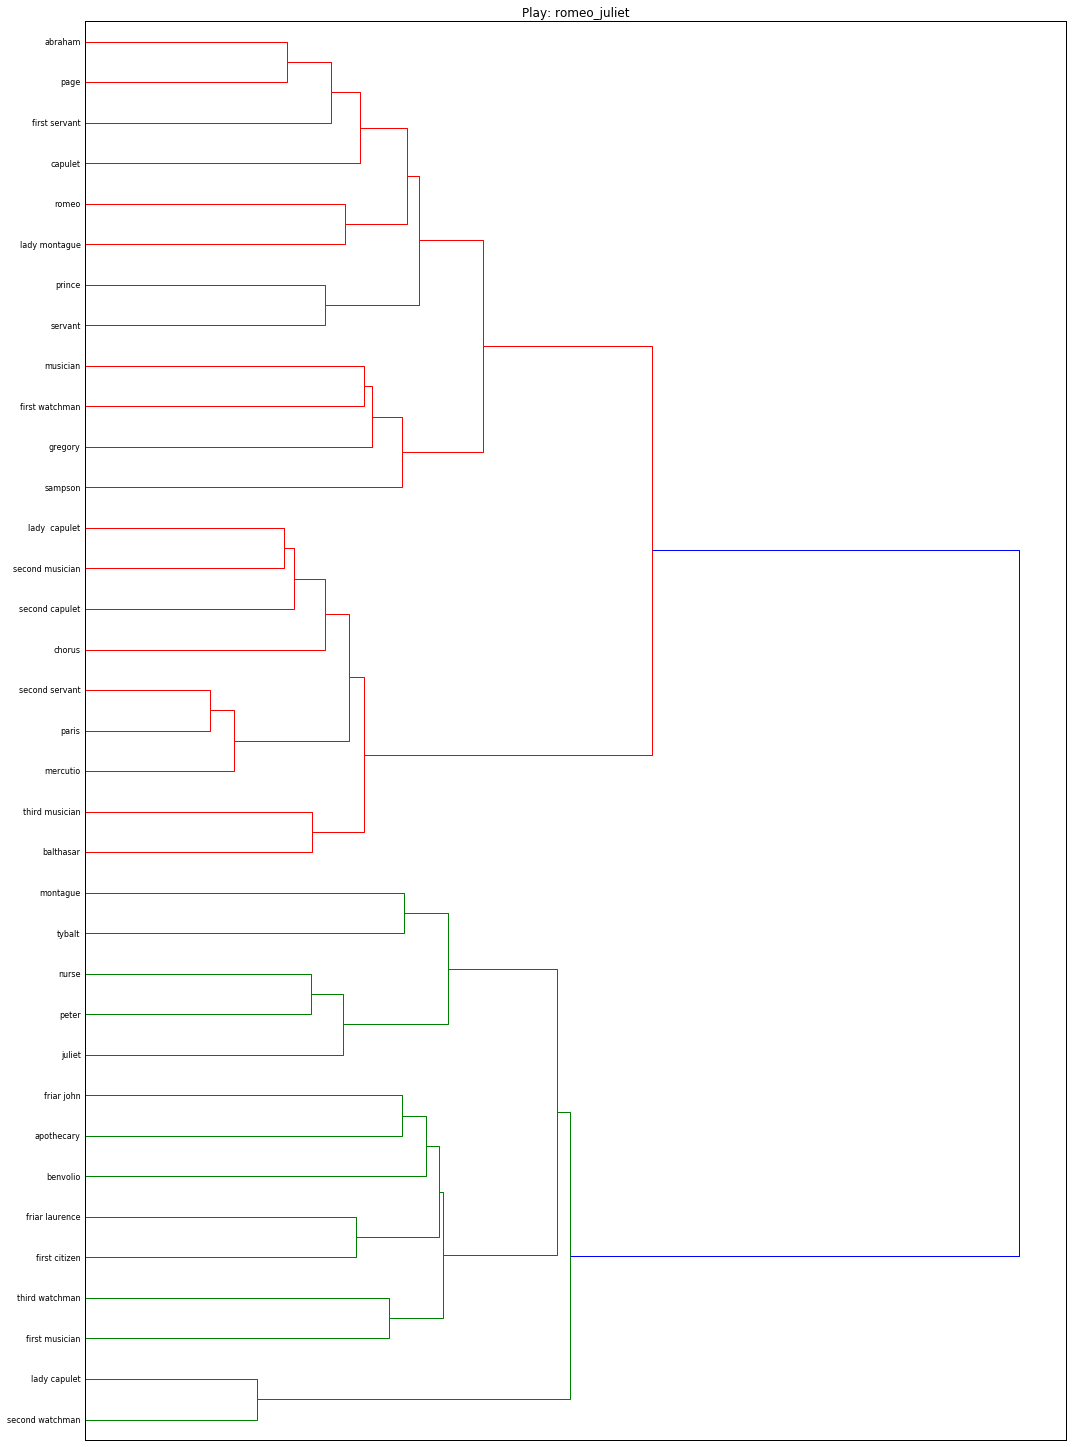

In [254]:
# distance metric
dist = 1 - cosine_similarity(tfidf_matrix)

vectorizer = TfidfVectorizer(max_df=.95, min_df=.05)
tfidf_matrix = vectorizer.fit_transform(prep_dict(list(set(text_df.character[text_df.play=='romeo_juliet'])), text_df).values()) 

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=list(set(text_df.character[text_df.play=='romeo_juliet'])));

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.title('Play: {0}'.format('romeo_juliet')) ## make this dynamic
plt.show()

#uncomment below to save figure
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [255]:
## insert hierarchical analysis here

## Appendix

## 1. Natural Language Tool Kit (NLTK) Tools Installation

Some of the NLTK tools used in this notebook required download and installation of items such as a corpus. In these cases, a terminal was opened, an ipython interpreter was launched and the command "nltk.download()" was executed. A pop-up window appeared where the corpus can be downloaded via a GUI. For more information, please see: http://www.nltk.org/data.html

### 2. Visualizations for all the characters, with Feature Reduction

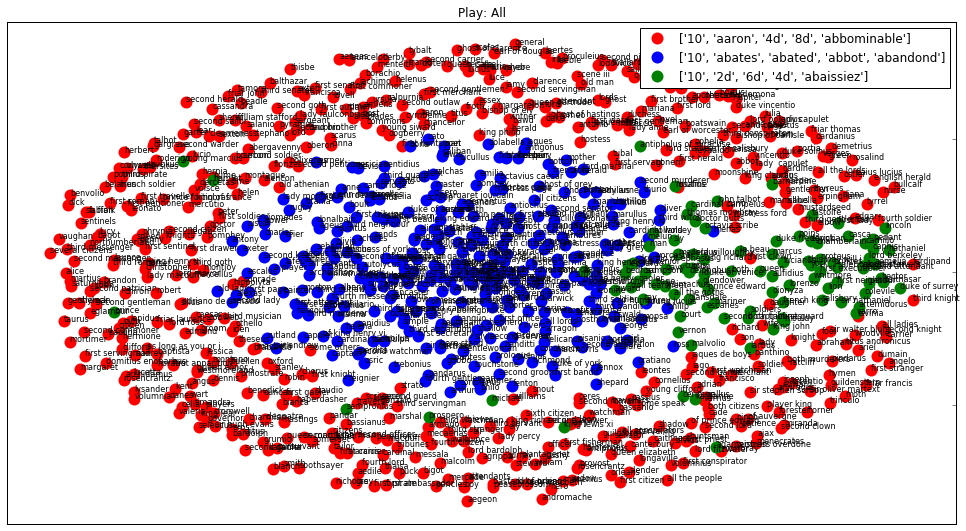

In [234]:
vectorizer = TfidfVectorizer(max_df=.95, min_df=.05)
clustering('All', list(set(text_df.character)), text_df, vectorizer, feat_reduct=True)

### 3. Visualizations for all the plays, without Feature Reduction

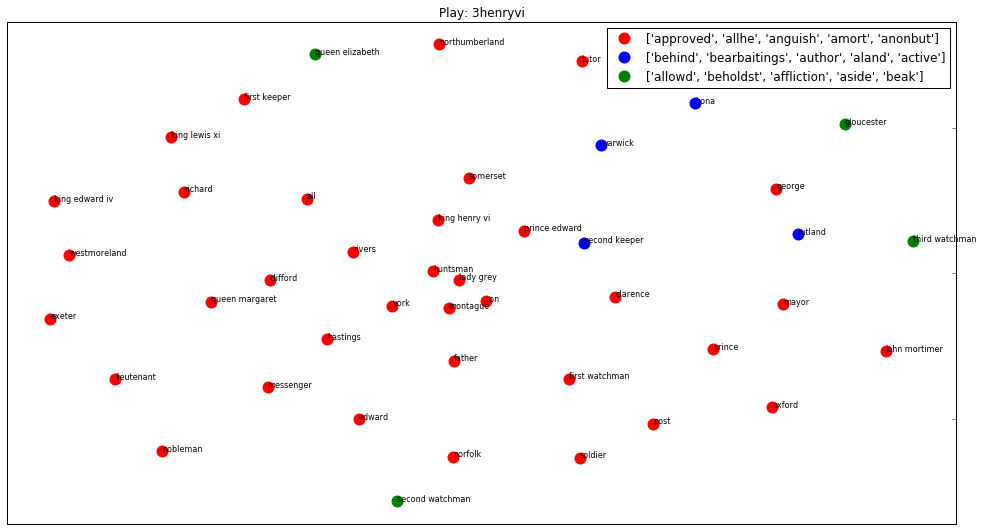

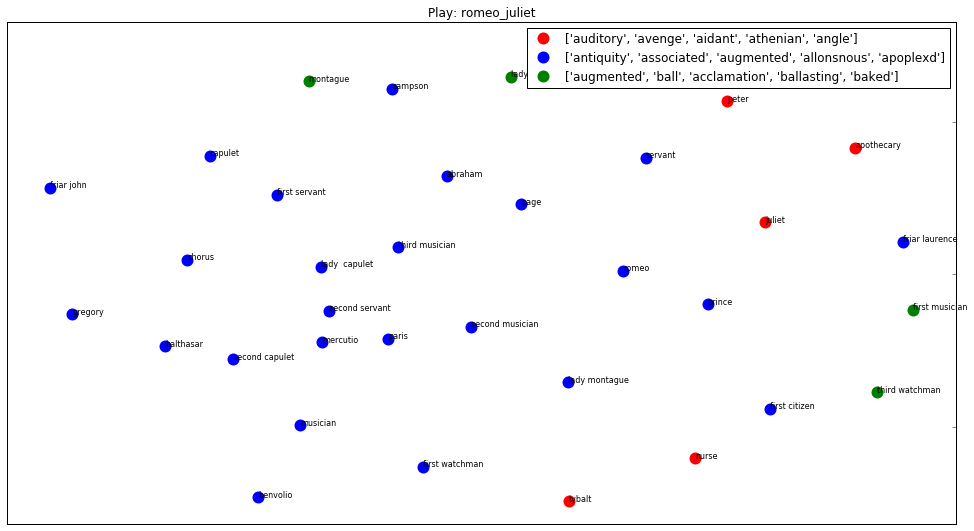

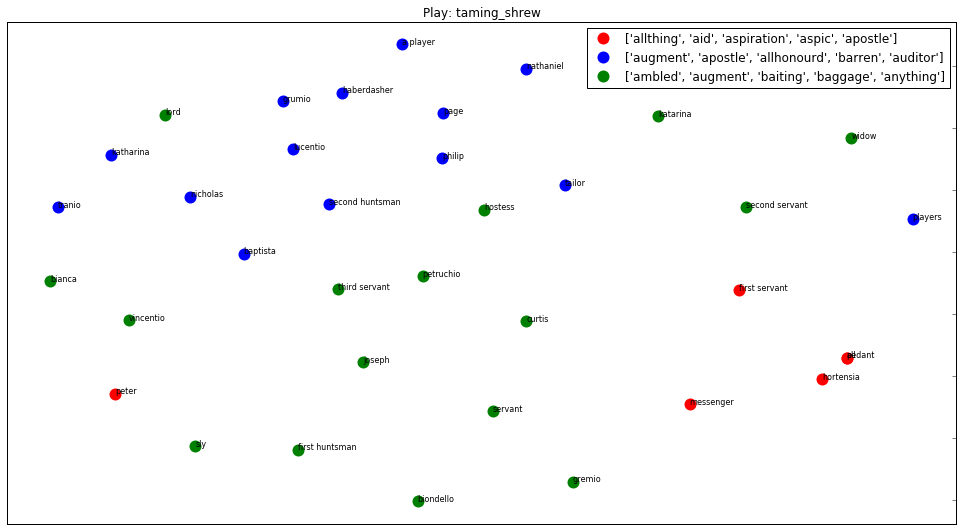

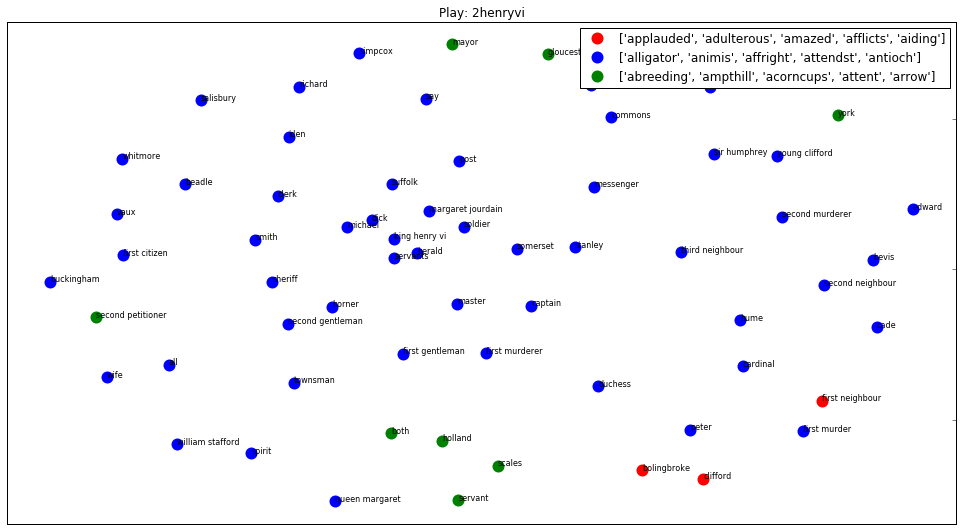

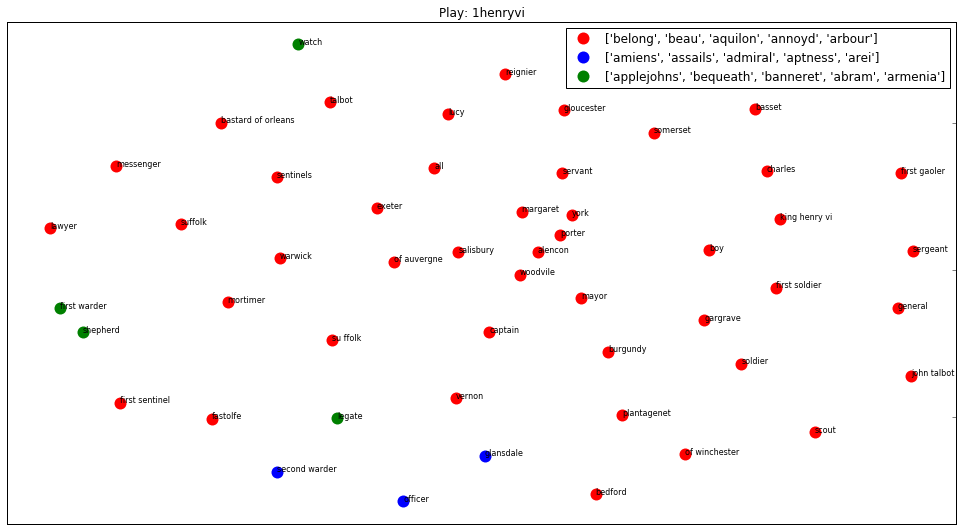

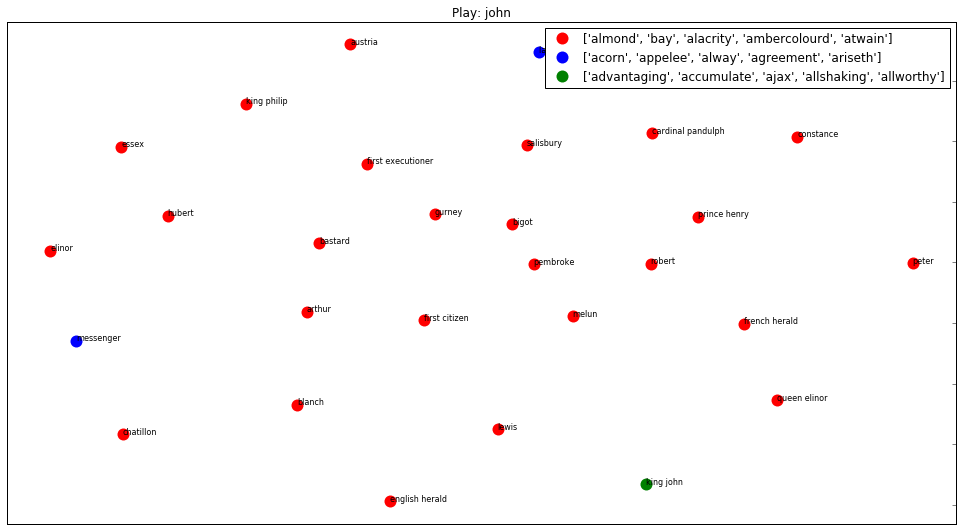

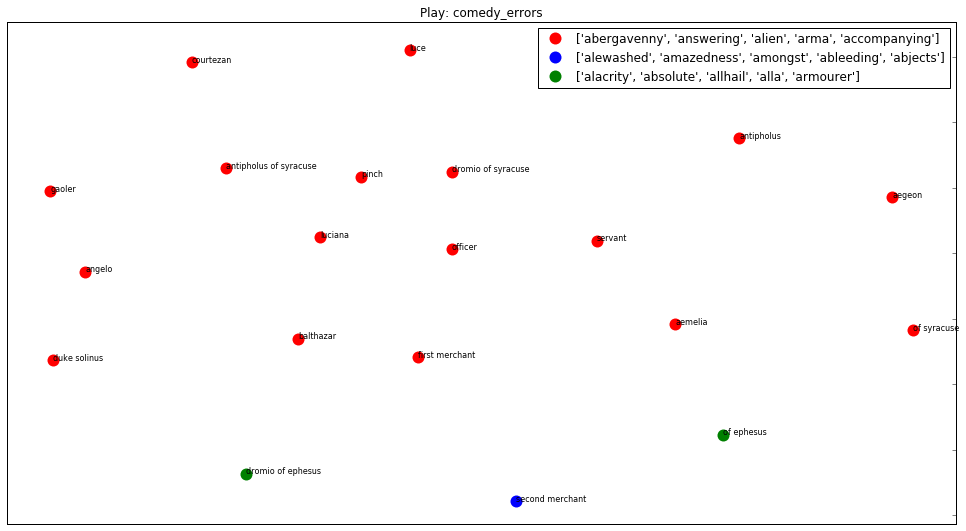

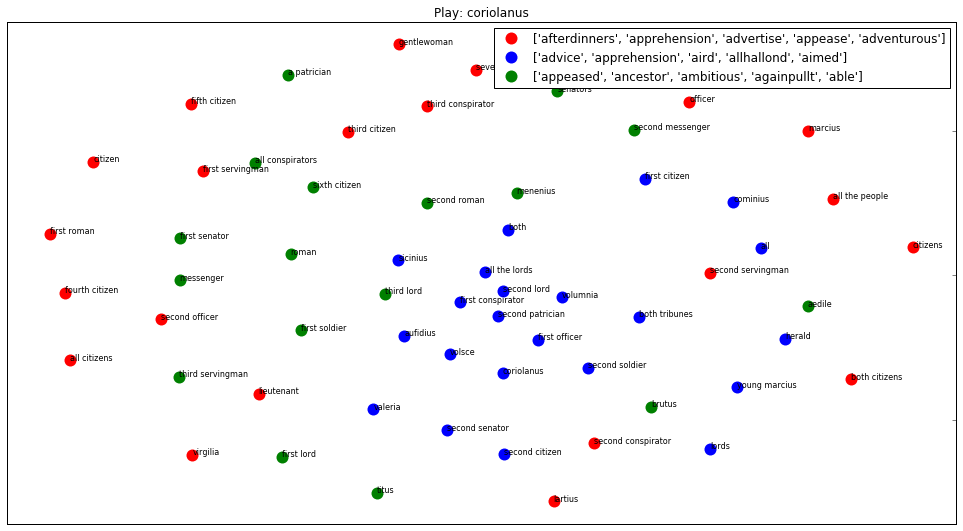

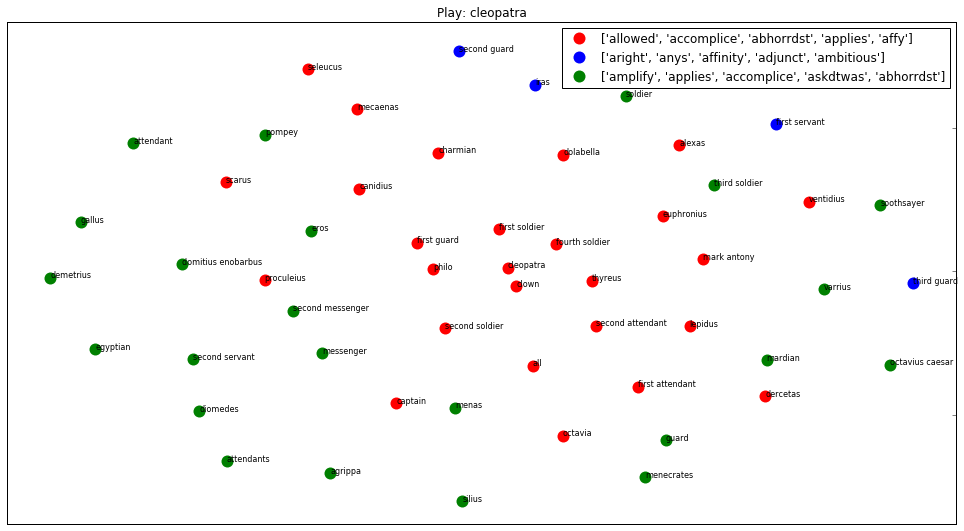

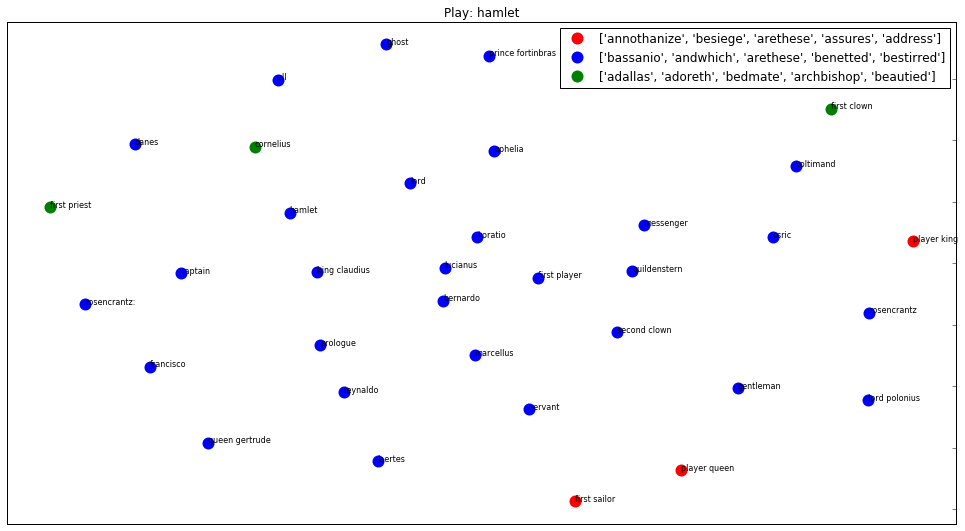

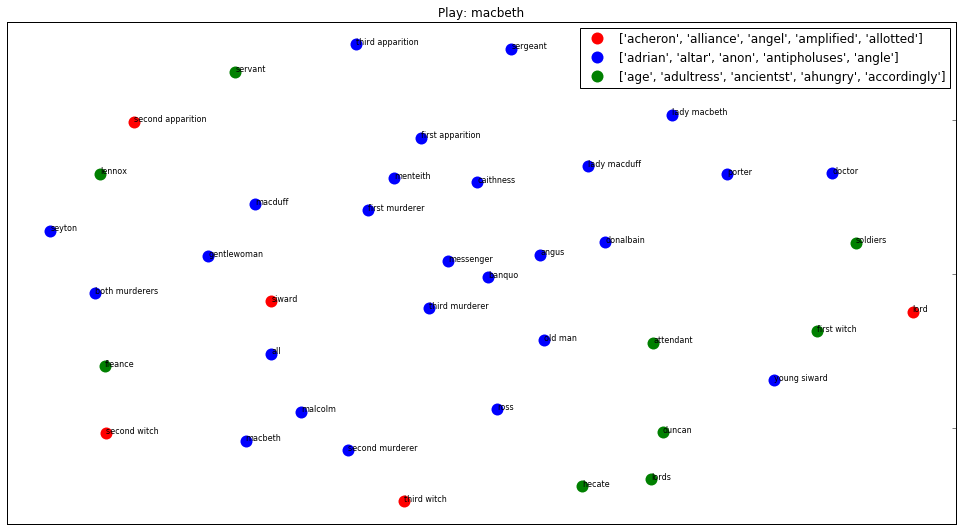

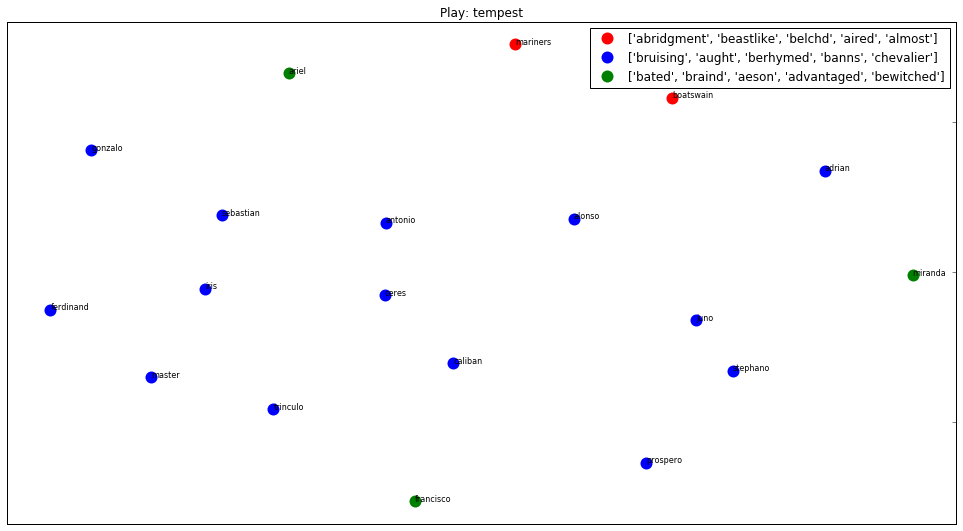

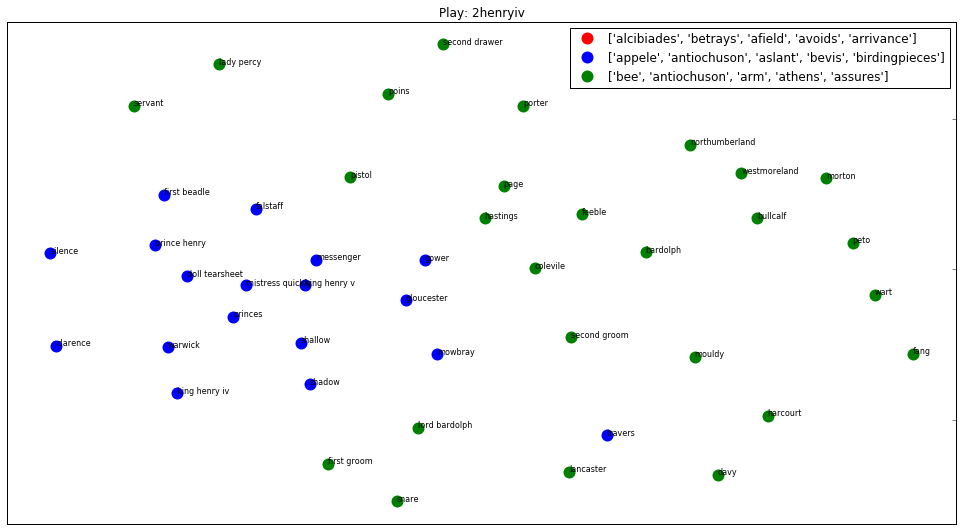

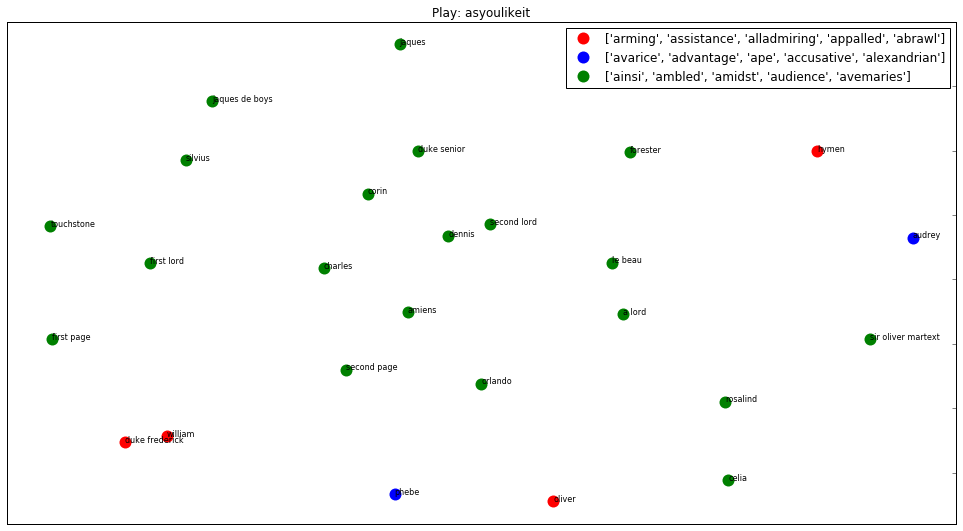

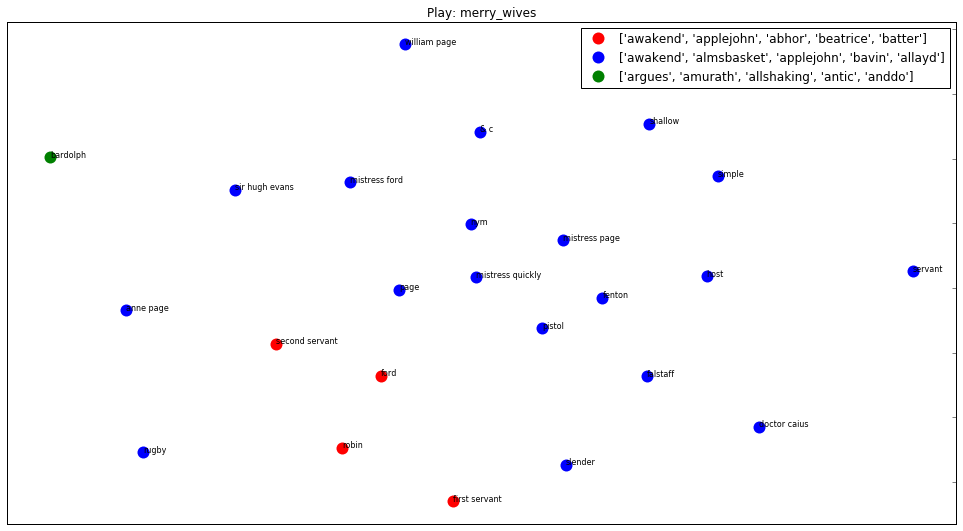

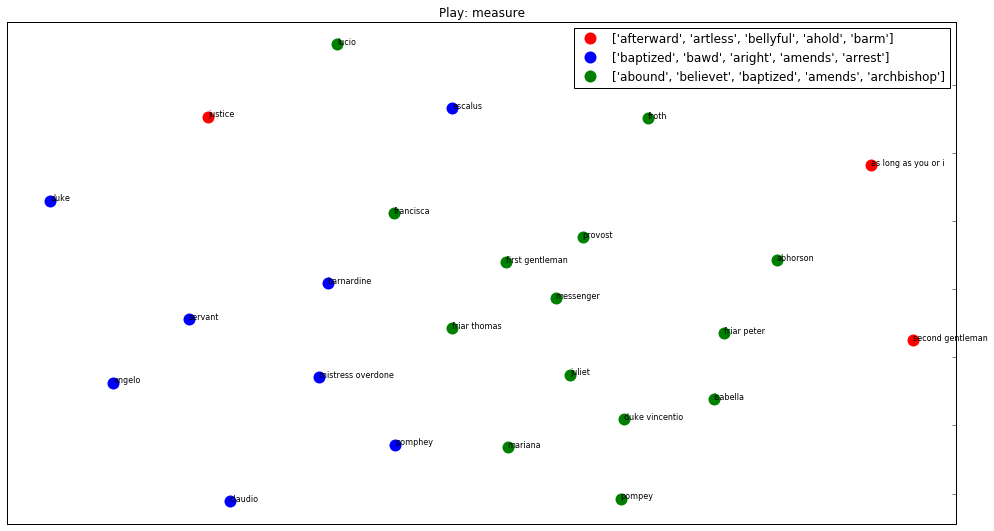

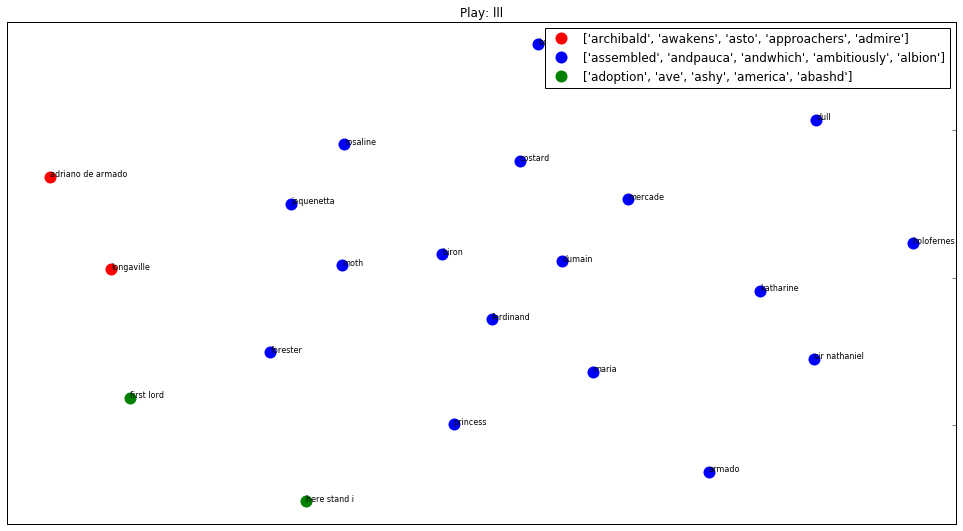

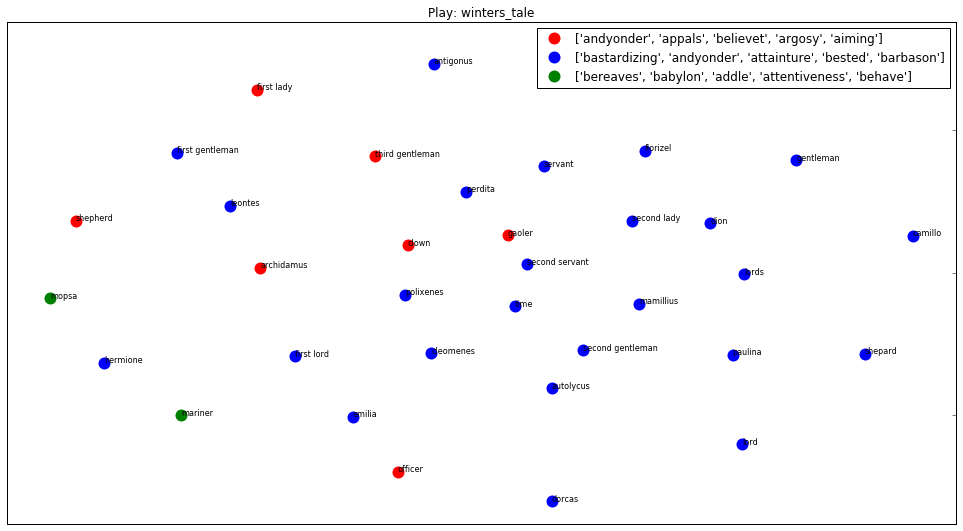

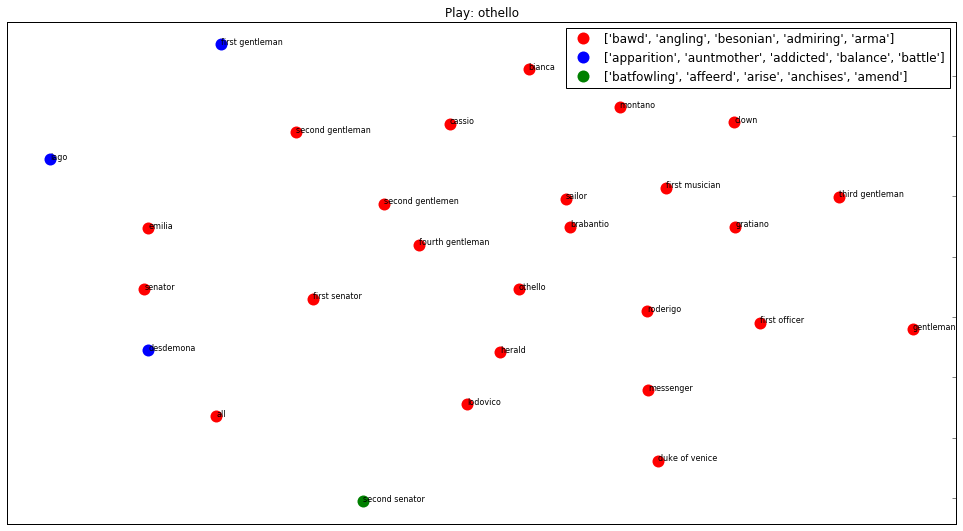

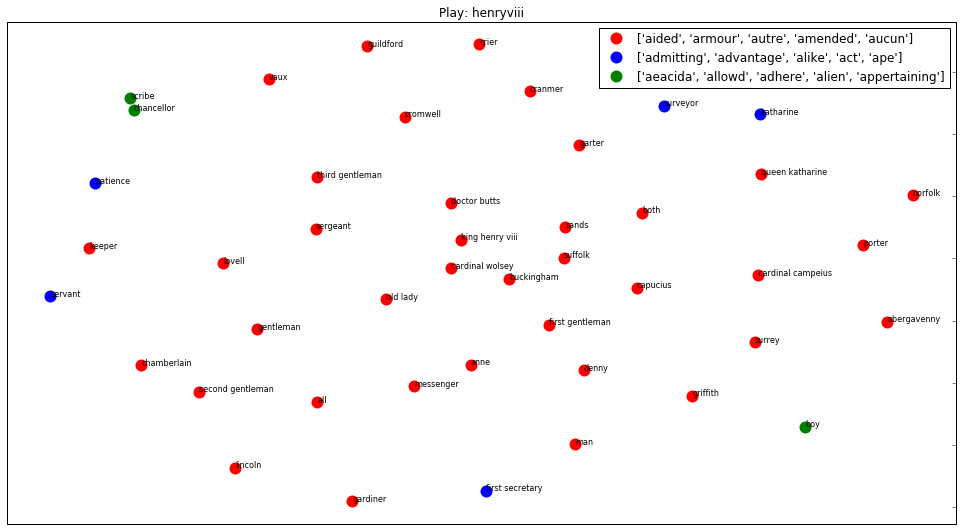

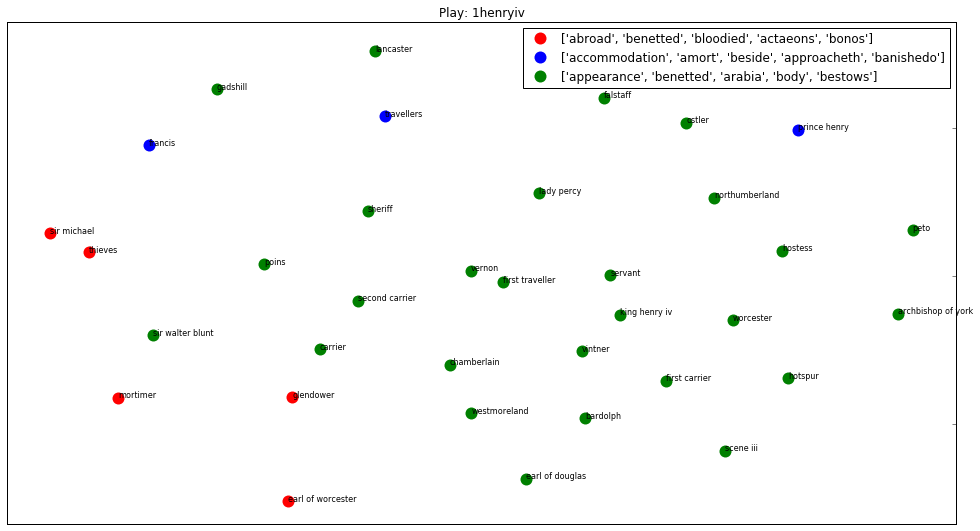

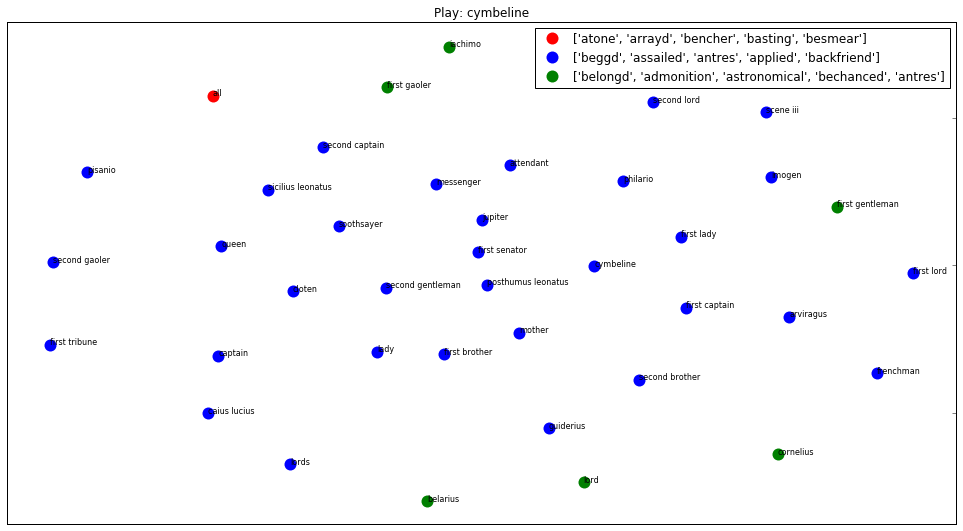

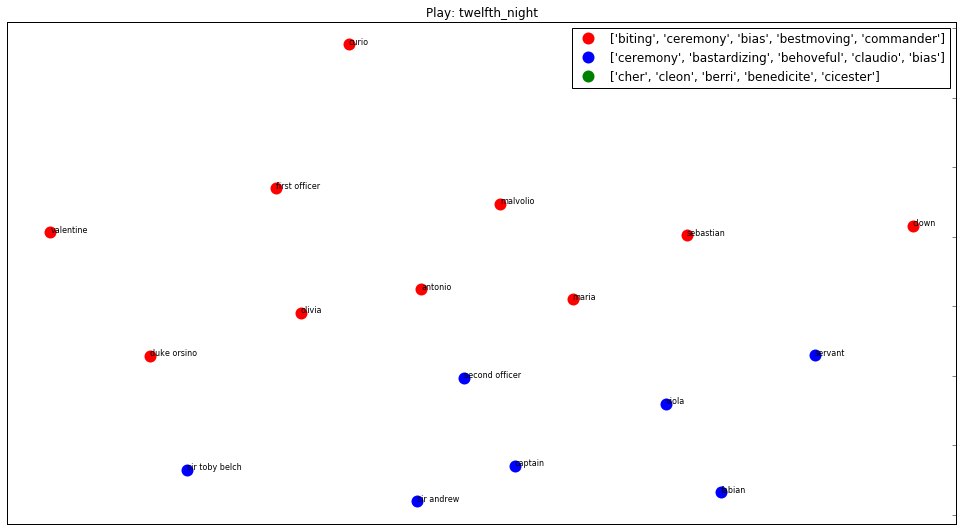

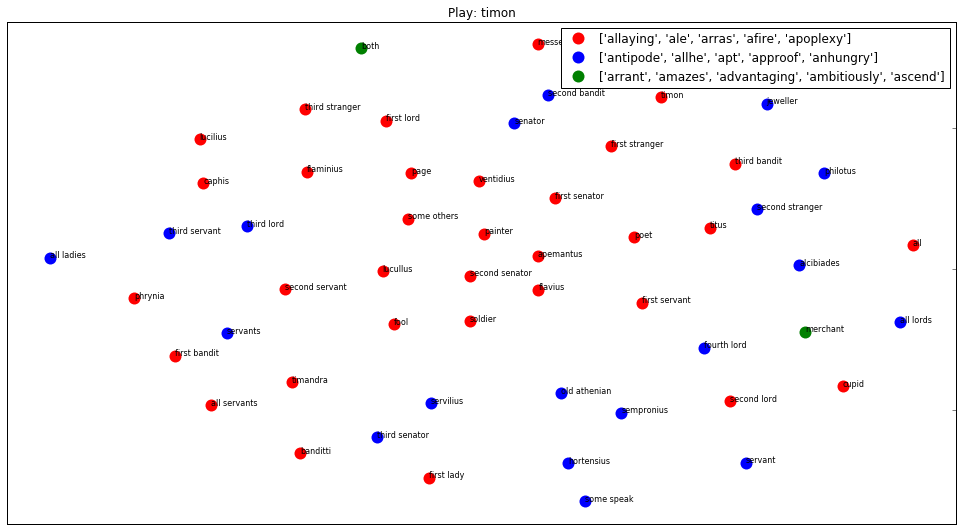

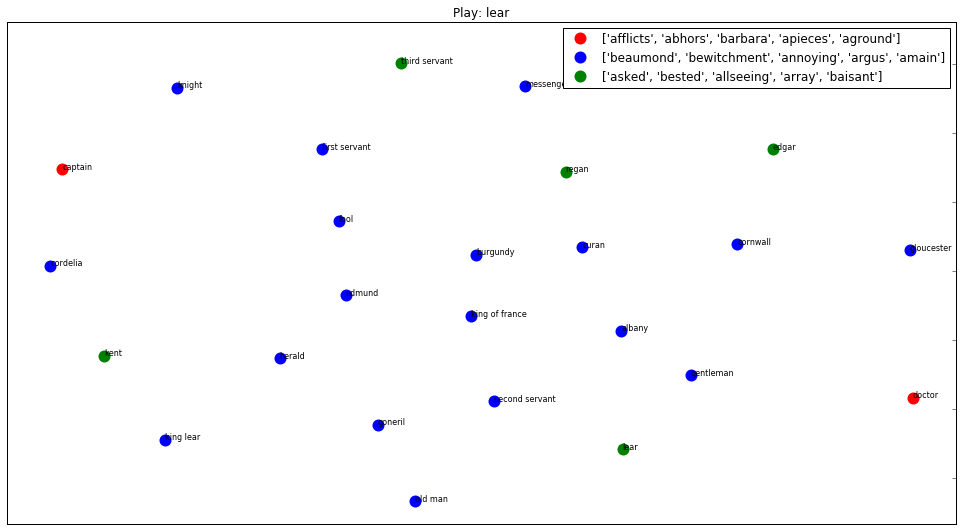

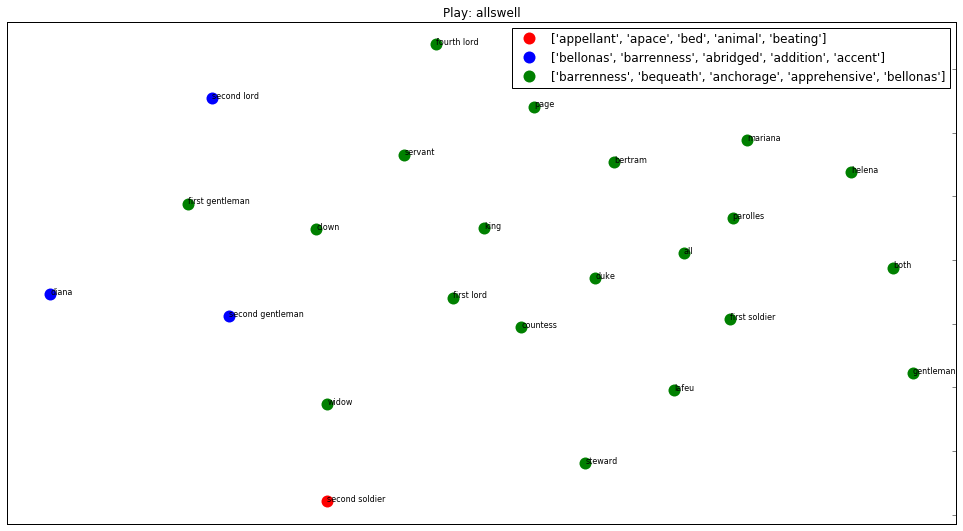

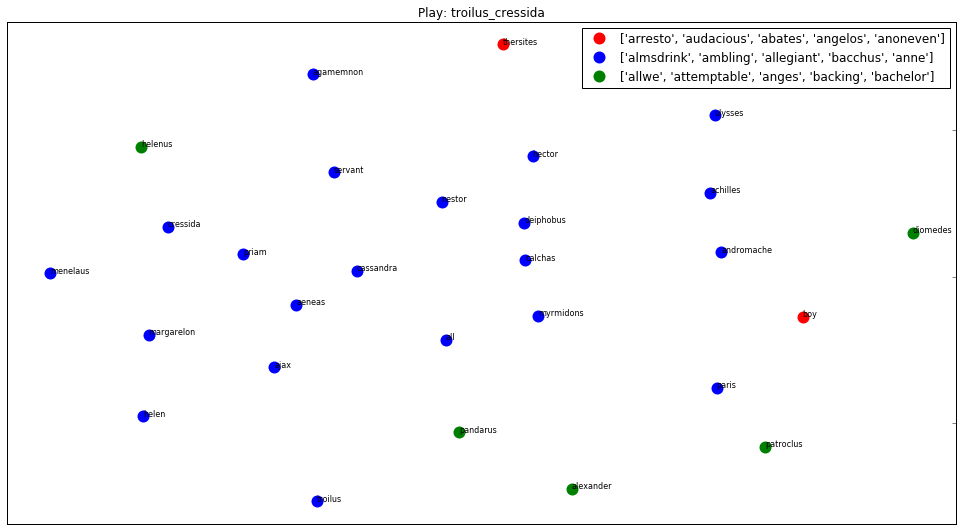

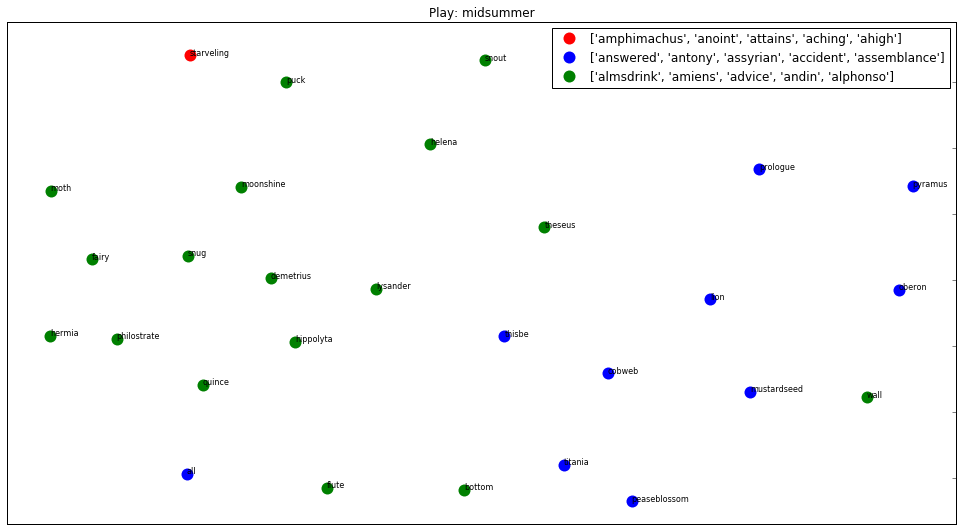

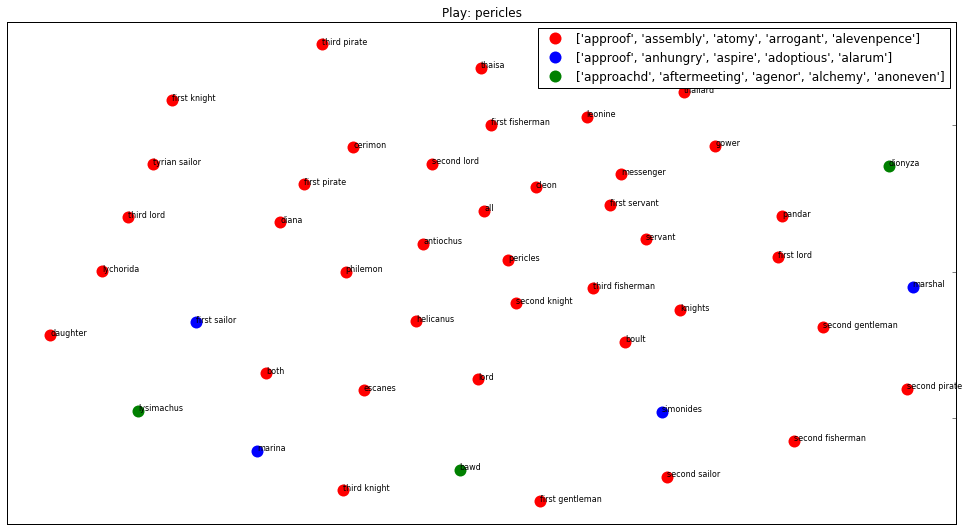

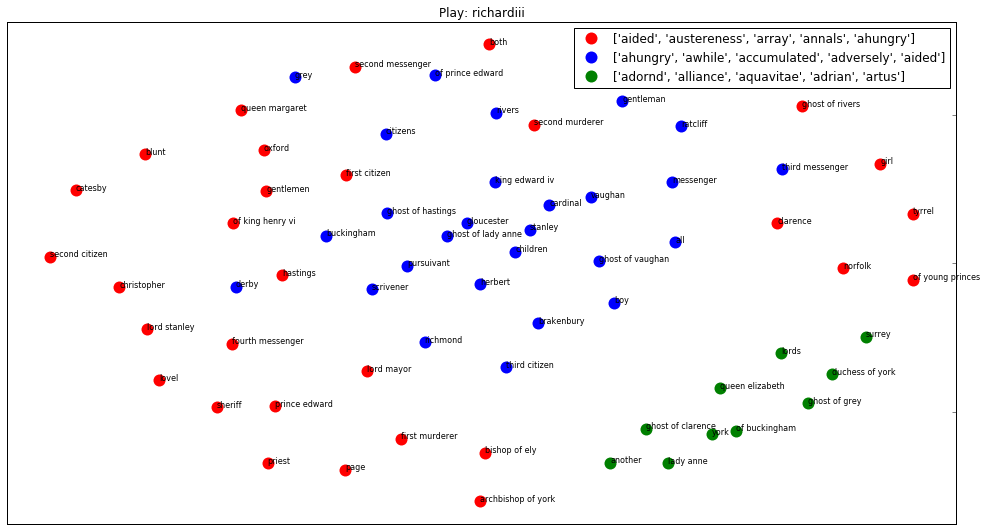

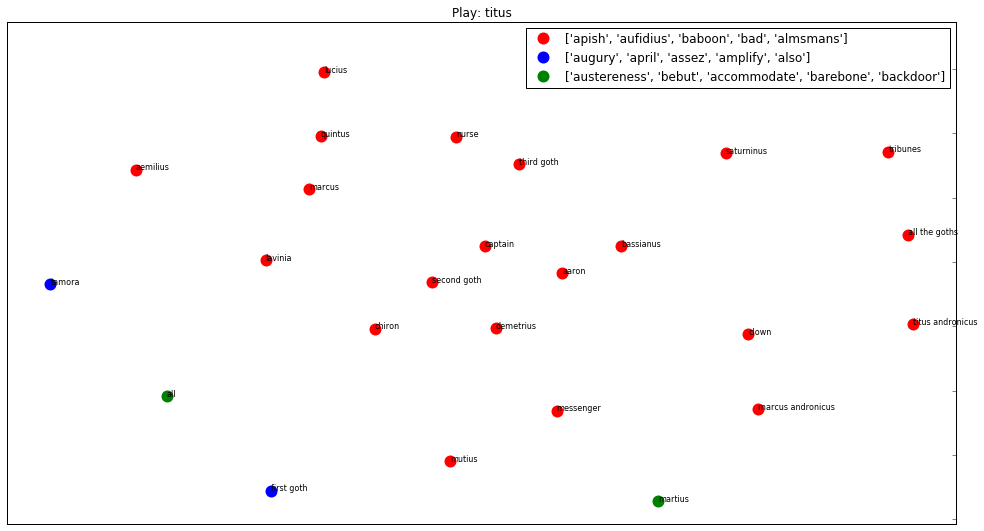

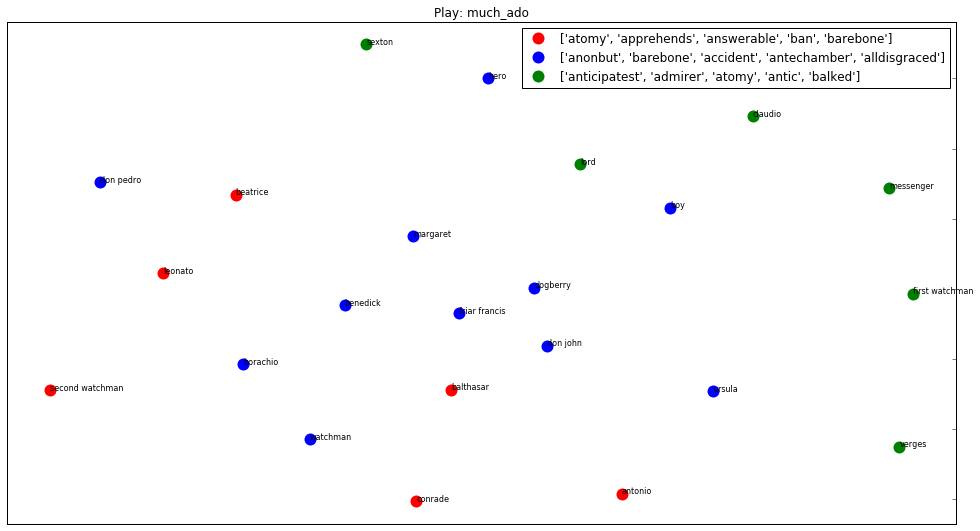

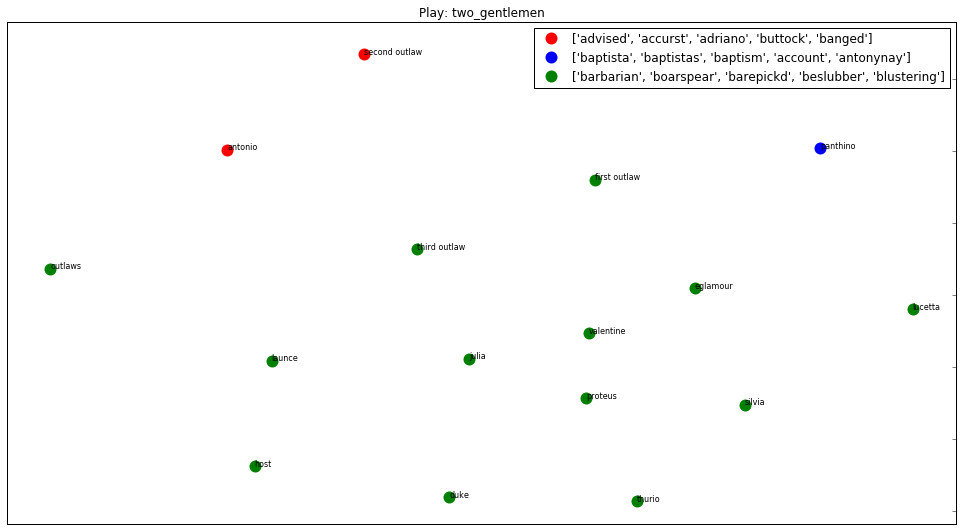

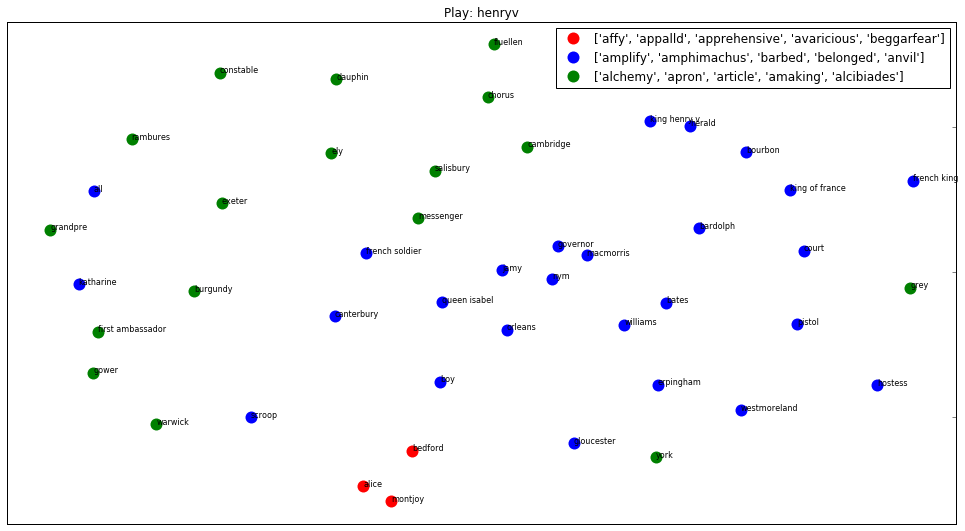

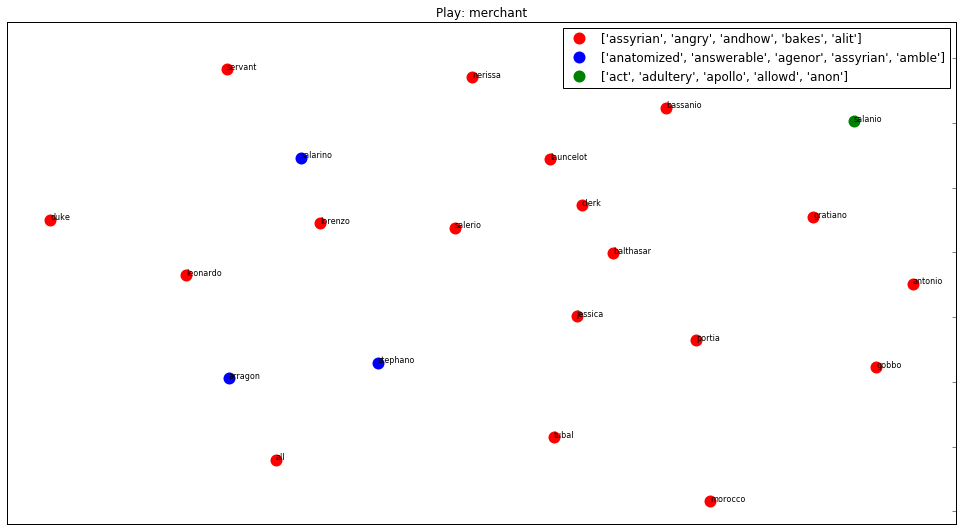

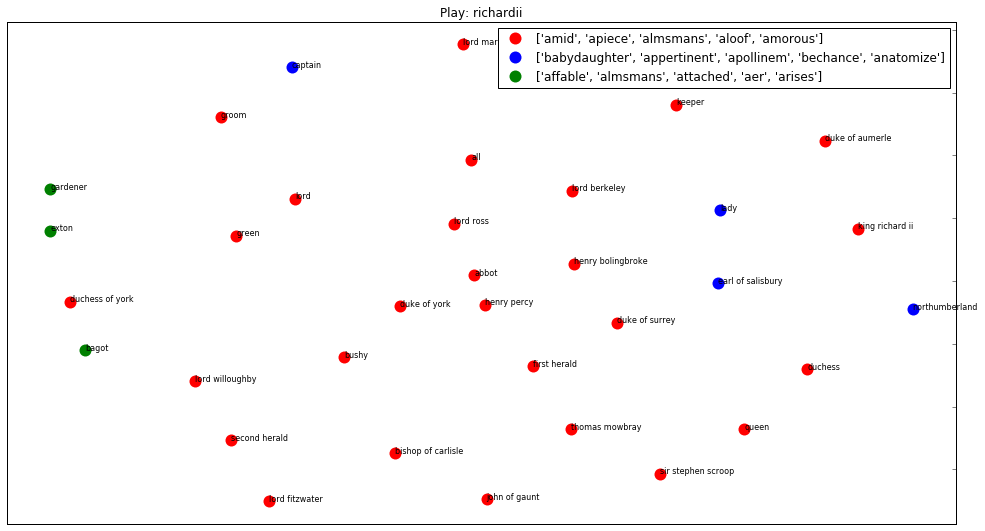

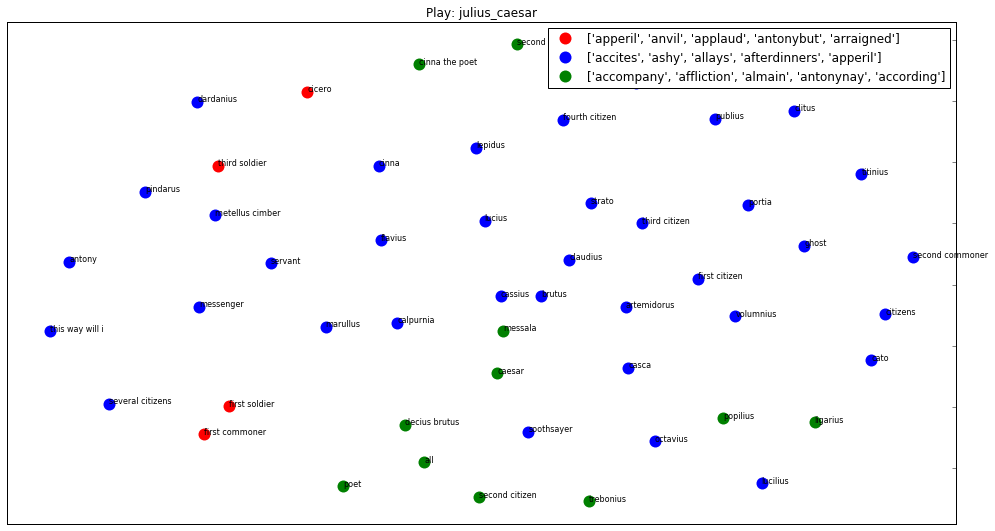

In [229]:
vectorizer = TfidfVectorizer(max_df=.95, min_df=.05)
for play, characters in play_character_dict.items():
    clustering(play, characters, text_df, vectorizer)

## 4. Dendogram for all of the characters

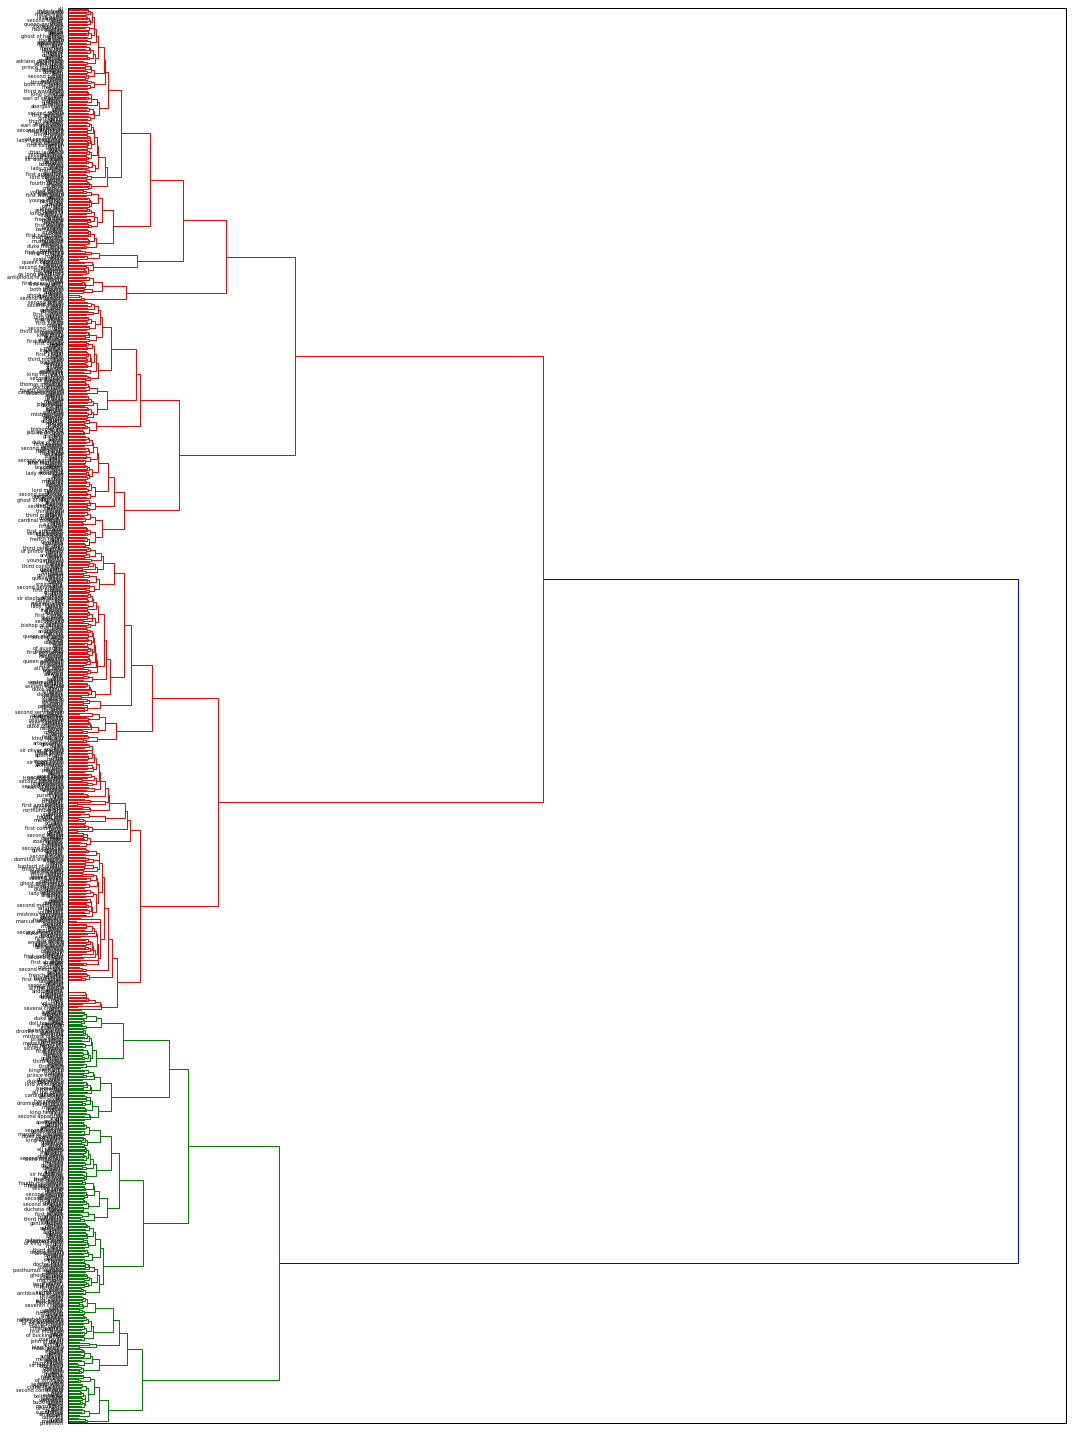

In [249]:
# distance metric
dist = 1 - cosine_similarity(tfidf_matrix)

vectorizer = TfidfVectorizer(max_df=.95, min_df=.05)
tfidf_matrix = vectorizer.fit_transform(prep_dict(list(set(text_df.character)), text_df).values()) 

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=list(set(text_df.character)));

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters